In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
import json
 
default = {'scenario': 'houston','project':'houston','training_folder':'../../scenarios'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))


In [2]:
def get_filepath(path,filename):
    '''
    get filePath cas insensitive (ex: read demand.csv but file is name DEMAND.csv)
    path:'path/ ex: '../../scenarios/base/inputs/'
    filename: ex: demand.csv
    '''
    files = os.listdir(path)
    file = [file for file in files if filename.lower() == file.lower()]
    if len(file)==0:
        print(f'{path+filename} does not exist')
        return path+filename
    return path+file[0]

In [3]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)
from syspy.spatial import spatial, polygons

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

PyTables is not installed. No support for HDF output.
num cores: 8


In [4]:
scenario = argv['scenario']

base_folder = os.path.join(argv['training_folder'],argv['scenario'])
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
od_folder =  os.path.join(input_folder,'od/')
params_folder = input_folder if on_lambda else '../../inputs/'

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(base_folder, 'model/')


In [5]:
var = excel.read_var(file=os.path.join(params_folder,'parameters.xlsx'), scenario=scenario, return_ancestry=False)
if 'params' in argv.keys():
    var.update(pd.DataFrame.from_dict(argv['params'], orient="index").stack())

# inputs

In [6]:
links = gpd.read_file(pt_folder + 'links.geojson', engine=io_engine) 
nodes = gpd.read_file(pt_folder + 'nodes.geojson', engine=io_engine)
links = links.set_index('index')
nodes = nodes.set_index('index')

In [7]:
rnodes = gpd.read_file(road_folder + 'road_nodes.geojson', engine=io_engine)
rnodes = rnodes.set_index('index')
rlinks = gpd.read_file(road_folder + 'road_links.geojson', engine=io_engine)
rlinks = rlinks.set_index('index')

In [8]:
filepath = get_filepath(input_folder,'zones.geojson')
zones = gpd.read_file(filepath)
zones = zones.set_index('index')

In [9]:
zones

,density,population,jobs,NAME,macro_zones,geometry
index,,,,,,
1,14.0,2464,383,Census Tract 7601,None,"MULTIPOLYGON (((-96.02022 29.69952, -96.02070 ..."
2,28.6,2078,612,Census Tract 7602.01,None,"MULTIPOLYGON (((-96.04924 29.80319, -96.04942 ..."
3,56.9,4450,938,Census Tract 7602.02,None,"MULTIPOLYGON (((-96.03308 29.72944, -96.03328 ..."
4,26.5,2773,936,Census Tract 7603.01,None,"MULTIPOLYGON (((-96.20546 29.88086, -96.20548 ..."
5,19.8,5043,2220,Census Tract 7603.02,None,"MULTIPOLYGON (((-96.31808 29.86316, -96.31877 ..."
...,...,...,...,...,...,...
1607,32.3,4879,1524,Census Tract 6805.01,None,"MULTIPOLYGON (((-96.05317 30.10388, -96.05321 ..."
1608,18.2,4337,561,Census Tract 6805.02,None,"MULTIPOLYGON (((-95.95036 30.23691, -95.95378 ..."
1609,39.5,2639,313,Census Tract 6806.01,None,"MULTIPOLYGON (((-95.80381 30.14372, -95.80427 ..."


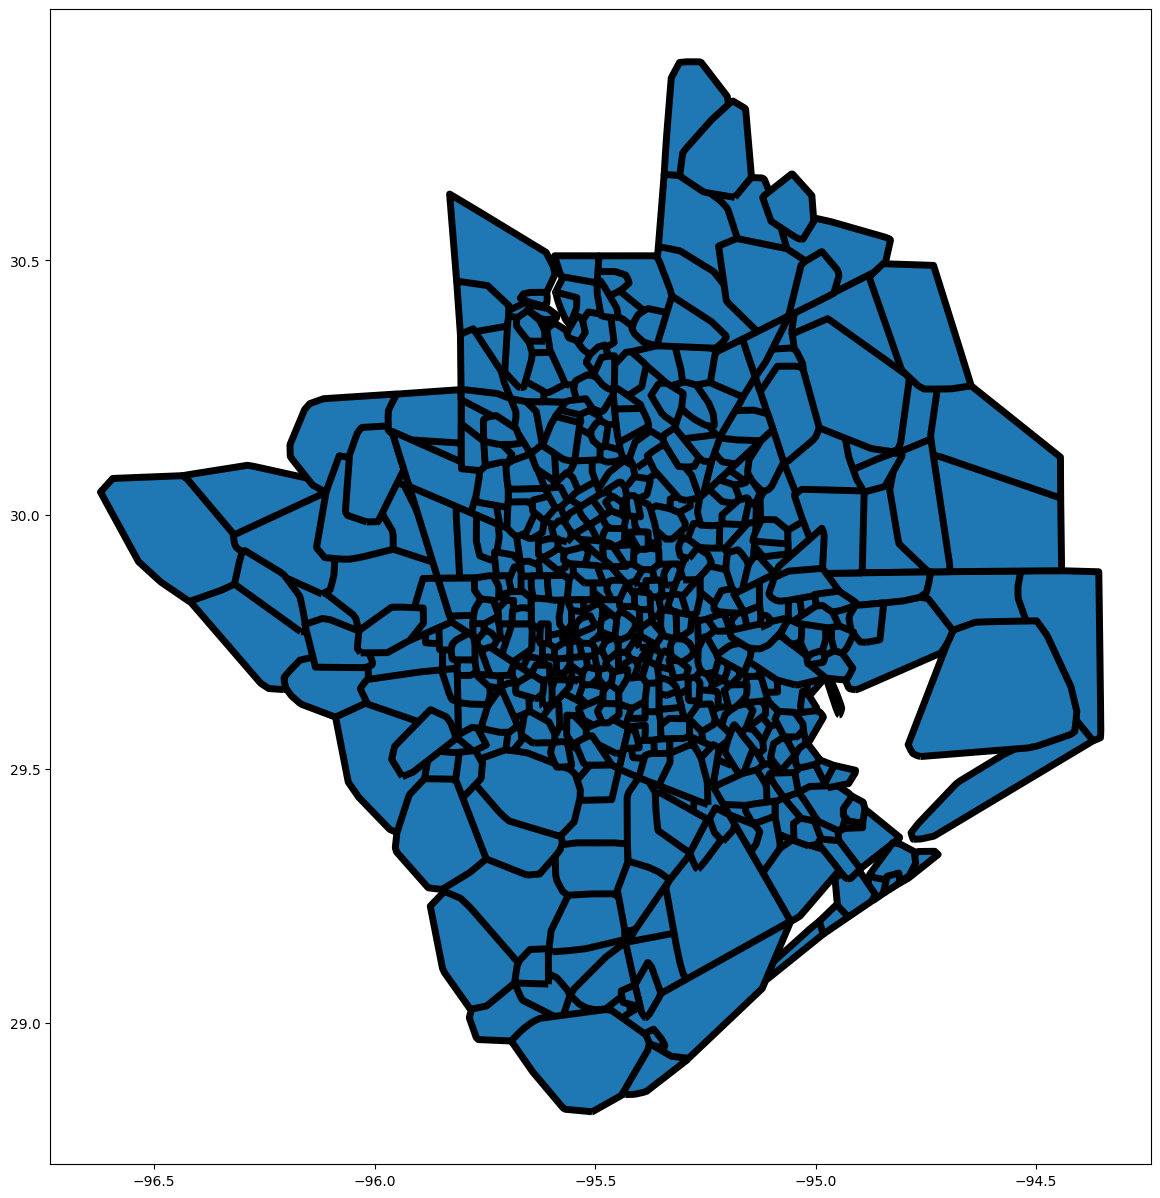

In [10]:
clusters = var['network_preparation']['n_clusters'] 

a, b = spatial.zone_clusters(zones, n_clusters=clusters)
plot = gpd.GeoDataFrame(a).plot(figsize=[25, 15], edgecolor='black', linewidth=5)


In [11]:
b

index
1       108
2        94
3       233
4       200
5        37
       ... 
1607    177
1608     42
1609    123
1610    288
1611    238
Name: cluster, Length: 1611, dtype: int32

In [12]:
zones['cluster']= b
zones_agg = zones.groupby(['cluster'])['density', 'population', 'jobs'].sum()
zones_agg =gpd.GeoDataFrame(zones_agg, geometry= a['geometry'])
zones_agg

,density,population,jobs,geometry
cluster,,,,
0,14881.3,17746,2182,"POLYGON ((-95.59706 29.66061, -95.59731 29.660..."
1,2268.8,17904,13757,"POLYGON ((-95.30156 29.95217, -95.30225 29.952..."
2,7890.2,20528,3905,"POLYGON ((-95.07368 29.47774, -95.08873 29.493..."
3,2418.2,15187,7402,"POLYGON ((-95.46646 30.17644, -95.47555 30.176..."
4,16441.9,23824,7263,"POLYGON ((-95.44702 29.68742, -95.44783 29.724..."
...,...,...,...,...
495,4360.0,17132,705,"POLYGON ((-95.28015 29.80248, -95.29017 29.804..."
496,272.8,2636,315,"POLYGON ((-95.54258 30.34240, -95.55868 30.347..."
497,7877.0,13450,13117,"POLYGON ((-95.45774 29.75946, -95.48620 29.769..."


In [13]:
zones

,density,population,jobs,NAME,macro_zones,geometry,cluster
index,,,,,,,
1,14.0,2464,383,Census Tract 7601,None,"MULTIPOLYGON (((-96.02022 29.69952, -96.02070 ...",108
2,28.6,2078,612,Census Tract 7602.01,None,"MULTIPOLYGON (((-96.04924 29.80319, -96.04942 ...",94
3,56.9,4450,938,Census Tract 7602.02,None,"MULTIPOLYGON (((-96.03308 29.72944, -96.03328 ...",233
4,26.5,2773,936,Census Tract 7603.01,None,"MULTIPOLYGON (((-96.20546 29.88086, -96.20548 ...",200
5,19.8,5043,2220,Census Tract 7603.02,None,"MULTIPOLYGON (((-96.31808 29.86316, -96.31877 ...",37
...,...,...,...,...,...,...,...
1607,32.3,4879,1524,Census Tract 6805.01,None,"MULTIPOLYGON (((-96.05317 30.10388, -96.05321 ...",177
1608,18.2,4337,561,Census Tract 6805.02,None,"MULTIPOLYGON (((-95.95036 30.23691, -95.95378 ...",42
1609,39.5,2639,313,Census Tract 6806.01,None,"MULTIPOLYGON (((-95.80381 30.14372, -95.80427 ...",123


# split quenedi road links


In [14]:
from quetzal.engine.road_model import RoadModel, _reverse_geom

self = RoadModel(rlinks,rnodes,zones,ff_time_col='time')
self.split_quenedi_rlinks()
rlinks = self.road_links
to_delete = [col for col in self.road_links.columns if col.endswith('_r')]
rlinks.drop(columns=to_delete,inplace=True)
del self

# create Model

In [15]:
sm = stepmodel.StepModel(epsg=4326)
sm.links = links
sm.nodes = nodes
sm.road_links = rlinks
sm.road_nodes = rnodes
sm.zones = zones_agg
sm.zones_before_clustering = zones

In [16]:
centroid = [*LineString(sm.nodes.centroid.values).centroid.coords][0]
crs = get_epsg(centroid[1],centroid[0])
crs

32615

In [17]:
sm = sm.change_epsg(crs,'meter')

Reprojecting model from epsg 4326 to epsg 32615: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


# clustering and walkmodel

In [18]:
sm.preparation_clusterize_nodes(distance_threshold=200)


In [19]:
#sm._add_type_prefixes({'nodes': 'node_','links':'link_','road_nodes':'road_node','road_links':'road_link_','zones':'zone_'})
sm._add_type_prefixes({'zones':'zone_'})

In [20]:
sm.road_links['walk_time'] = sm.road_links['length'] / var['footpaths']['wor_speed'] * 3.6

In [21]:
sm.preparation_footpaths(max_length=var['footpaths']['max_length'],
                         speed=var['footpaths']['speed'])


In [22]:
# Zone to transit
sm.preparation_ntlegs(
    short_leg_speed = var['zone_to_transit']['speed'],
    long_leg_speed = var['zone_to_transit']['speed'], # tout le monde marche
    threshold = var['zone_to_transit']['threshold'],
    zone_to_transit = True,
    zone_to_road = True,
    road_to_transit = True,
    n_ntlegs = var['zone_to_transit']['nbr'],
    max_ntleg_length = var['zone_to_transit']['max_length'],
)
sm._add_type_prefixes({'zone_to_transit':'ztt_'})

In [23]:
sm.integrity_test_all(errors='ignore', verbose=True)

failed: integrity_test_circular_lines
passed: integrity_test_collision


47435it [00:01, 34052.09it/s]


passed: integrity_test_dead_ends
passed: integrity_test_duplicate_volumes
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency
failed: integrity_test_road_duplicated_ab_links


47435it [00:03, 14159.97it/s]


failed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences
passed: integrity_test_str_collision


In [24]:
sm.road_links.drop_duplicates(subset= ['a','b'], inplace=True)

In [25]:
sm.zones.to_file(input_folder + 'zones_agg.geojson', driver= 'GeoJSON')

In [26]:
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

sm.to_zippedpickles(model_folder +'network')  

broken_sequences: 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]       


In [27]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined